# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

In [2]:
import matplotlib.pyplot as plt
from statistics import NormalDist
import math

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [3]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=imprint', 'case/server=malicious-model'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=torch.float)
setup

Investigating use case single_imagenet with server type malicious_model.


{'device': device(type='cpu'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [4]:
cfg.case.user.num_data_points = 64
cfg.case.server.model_modification.type = 'SparseImprintBlock' 
cfg.case.server.model_modification.num_bins = 128
cfg.case.server.model_modification.position = None # '4.0.conv'
cfg.case.server.model_modification.connection = 'linear'


cfg.case.server.model_modification.linfunc = 'fourier'
cfg.case.server.model_modification.mode = 32

### Instantiate all parties

In [5]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture ResNet18 loaded with 50,375,336 parameters and 9,620 buffers.
Overall this is a data ratio of       5:1 for target shape [64, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 64

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: Subset
    user: 0
    
        
Server (of type MaliciousModelServer) with settings:
    Threat model: Malicious (Analyst)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ResNet18
        model state: default
        public buffers: True

    Secrets: {'ImprintBlock': {'weight_idx': 0, 'bias_idx': 1, 'shape': (3, 224, 224), 'structure': 'sparse'}}
    
Attacker (of type ImprintAttacker).


### Simulate an attacked FL protocol

True user data is returned only for analysis

In [6]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

In [7]:
#grads = shared_data['gradients'][0]
#[(g.norm(), g.mean(), g.std()) for g in grads]

In [8]:
#torch.norm(torch.stack([torch.norm(g, 2) for g in grads]), 2)

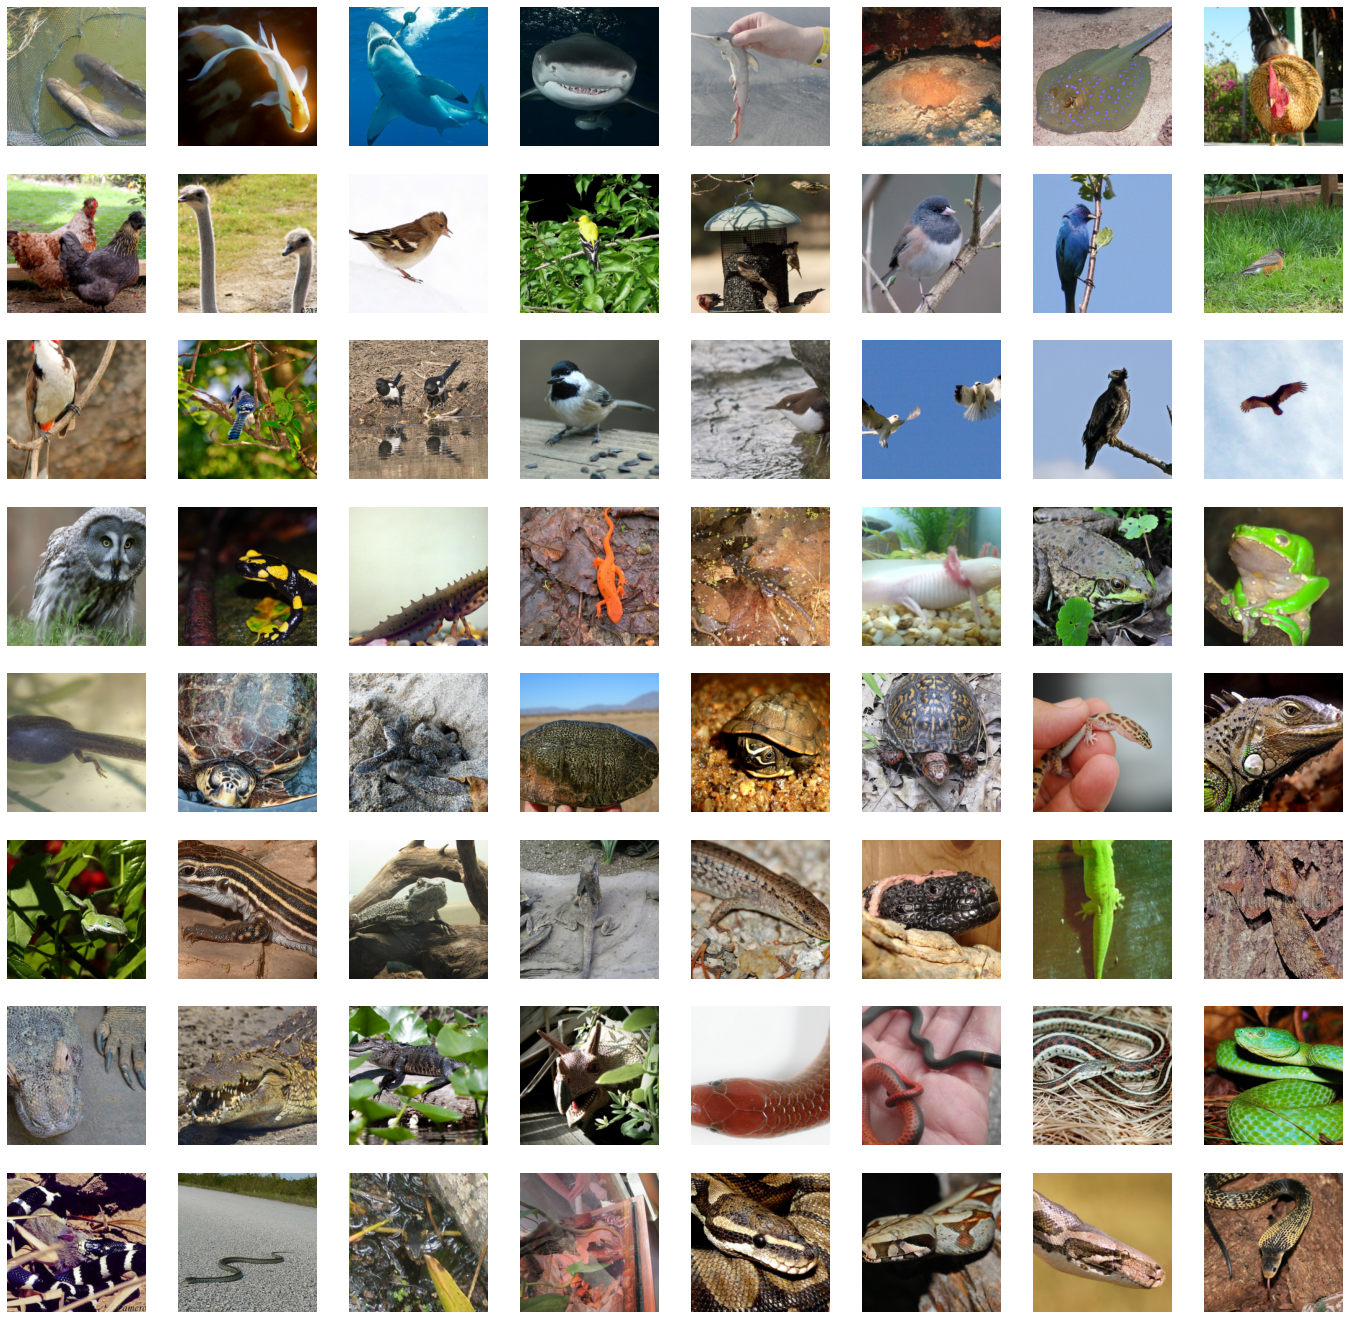

In [9]:
user.plot(true_user_data)

# Reconstruct user data

In [10]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

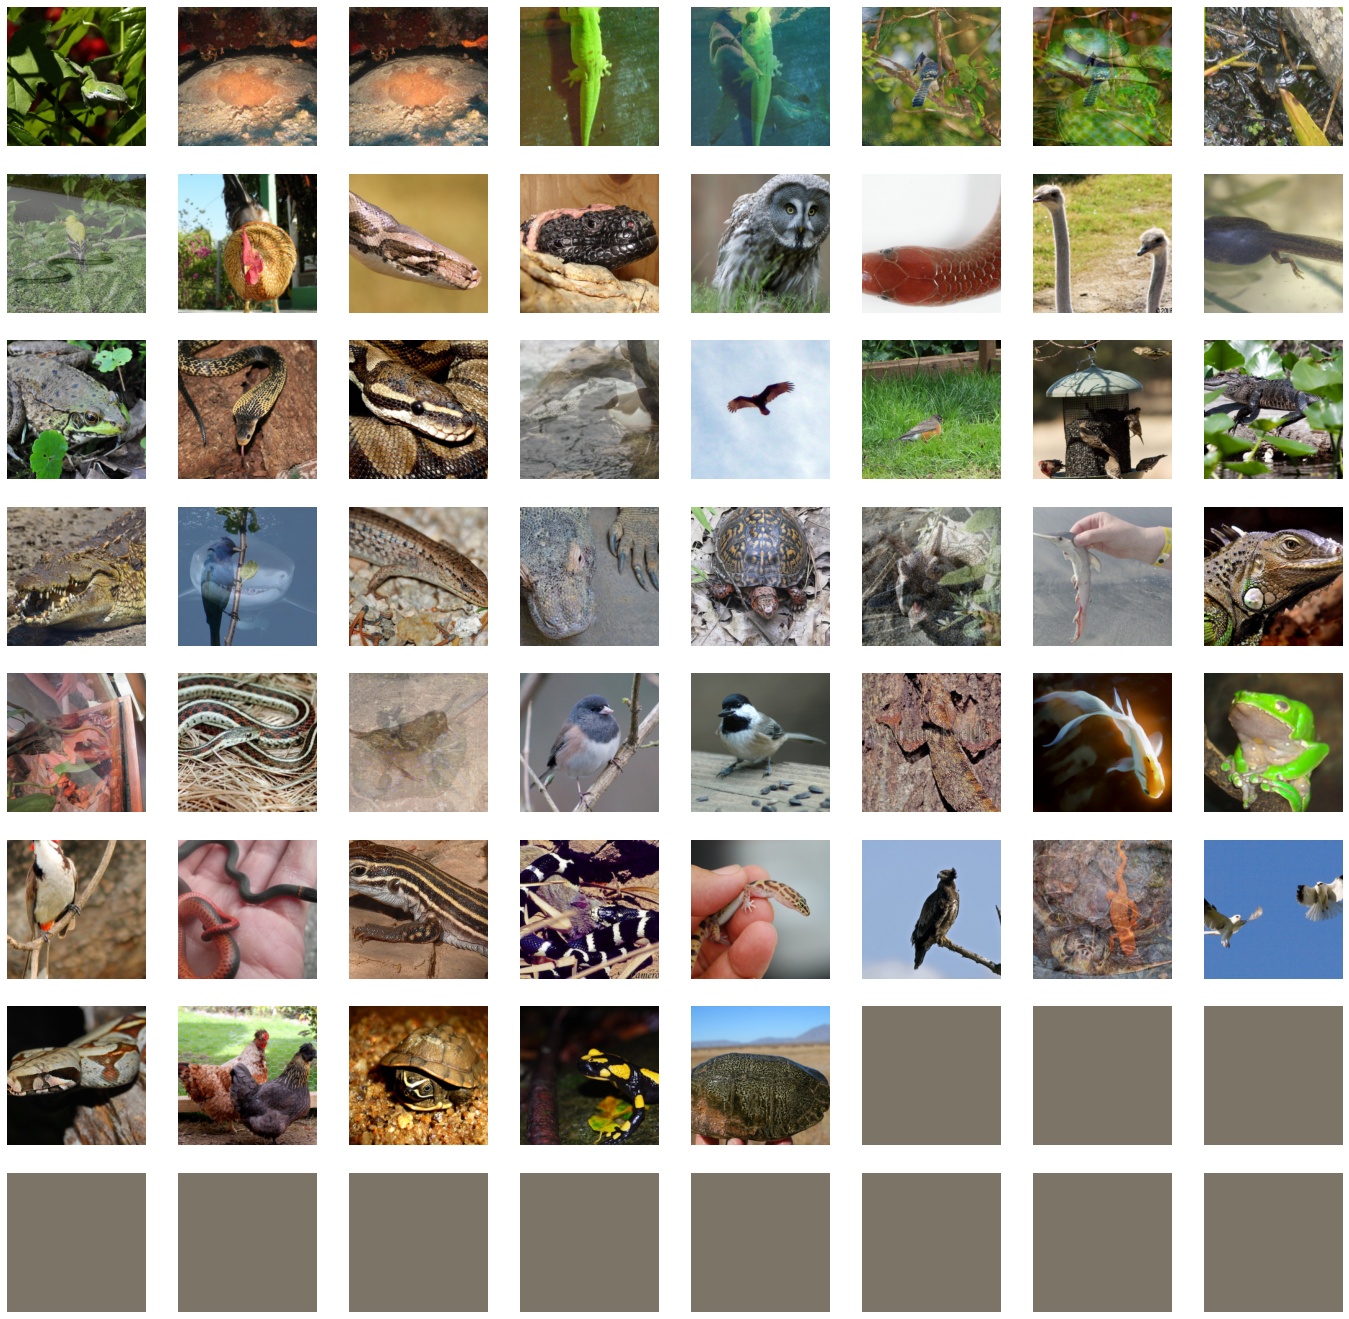

In [11]:
user.plot(reconstructed_user_data)

In [12]:
#How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

/home/jonas/anaconda3/envs/dl/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


METRICS: | MSE: 0.0201 | PSNR:  inf | FMSE: 9.3519e+01 | LPIPS: 0.22|
 R-PSNR:  inf | IIP-pixel: 78.12% | SSIM: 0.7619 | Label Acc: 0.00%


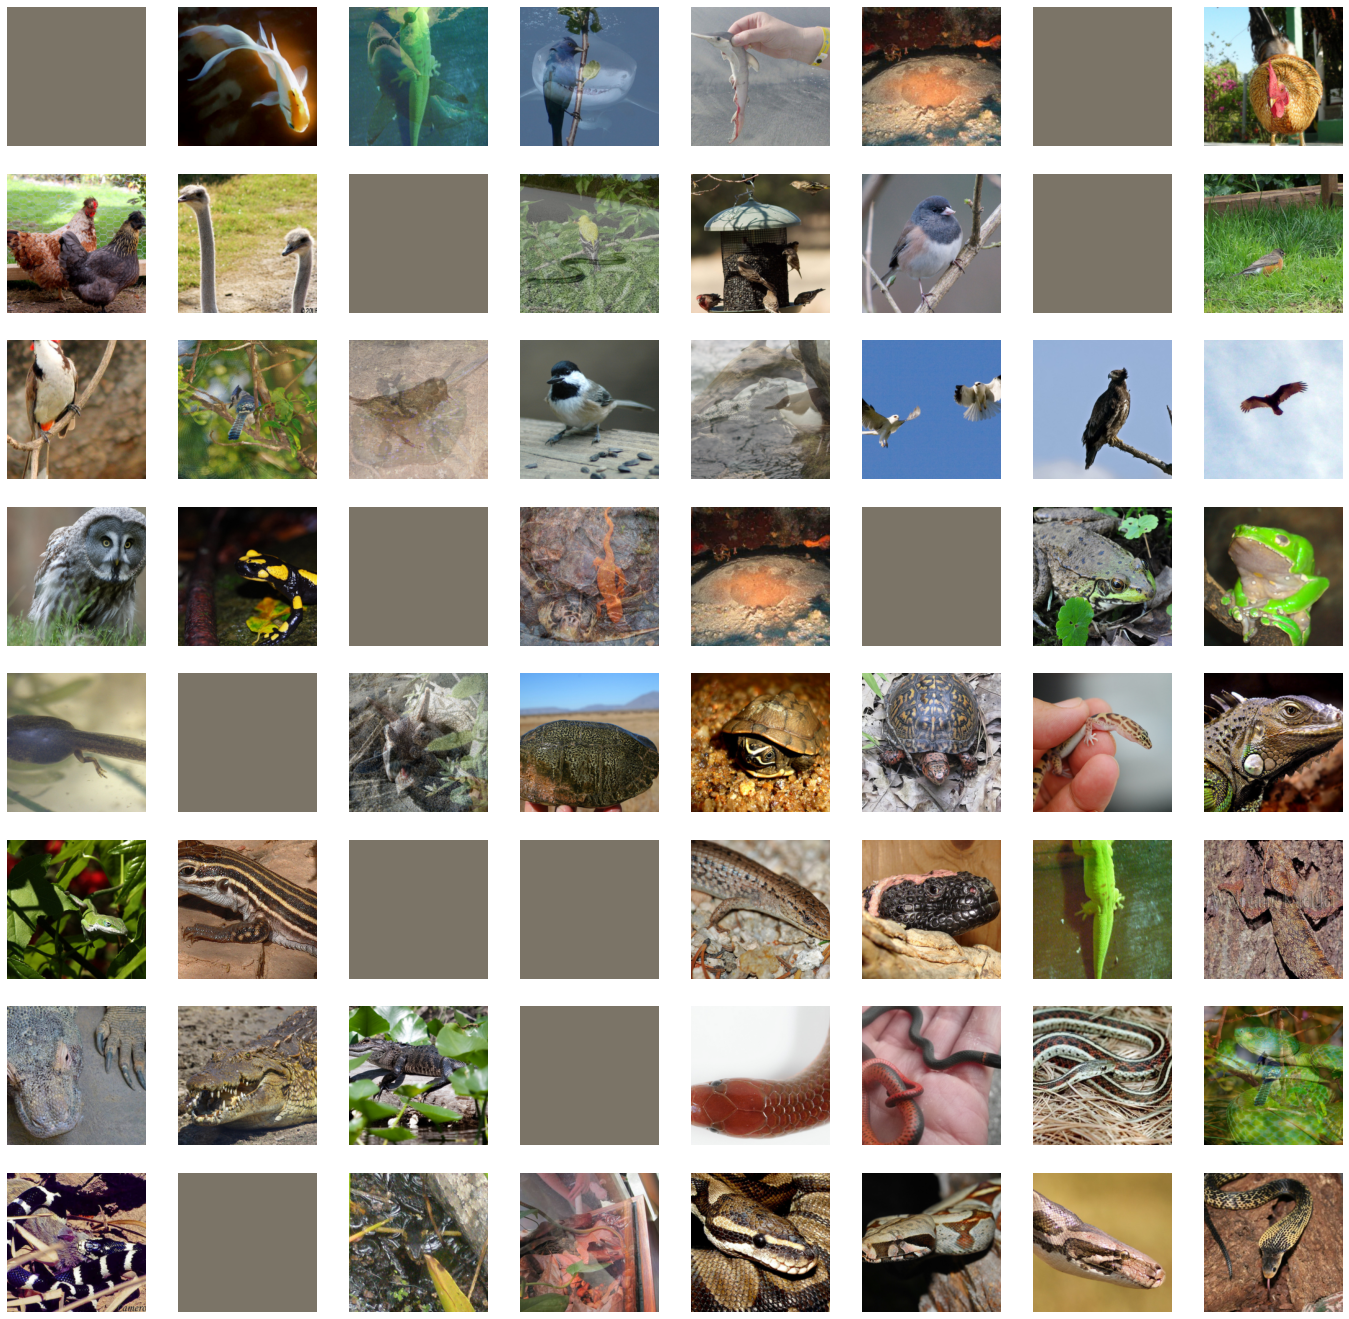

In [13]:
user.plot(reconstructed_user_data)

# Analyze distribution on ground truth data

This is not possible in general, but helpful as a sanity check

In [14]:
block_lin = user.model[1].linear0.weight[0]

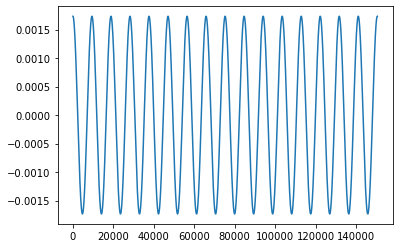

In [15]:
plt.plot(block_lin.detach().cpu().numpy())

In [16]:
cfg.case.data.name = "ImageNet"
dataloader = breaching.cases.construct_dataloader(cfg.case.data, cfg.case.impl, 
                                                  user_idx=None, return_full_dataset=True)

In [17]:
dataloader.dataset.transform

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [18]:
vals = torch.zeros(len(dataloader.dataset))
counter = 0
with torch.inference_mode():
    for image, _ in iter(dataloader):
        image = image.to(**setup)
        B = image.shape[0]
        vals[counter:counter+B] = (block_lin[None, :] * image.flatten(start_dim=1)).sum(dim=1).detach().cpu()
        counter += B

In [19]:
# vals = vals * torch.tensor(block_lin.shape[0])

In [20]:
from scipy.stats import laplace

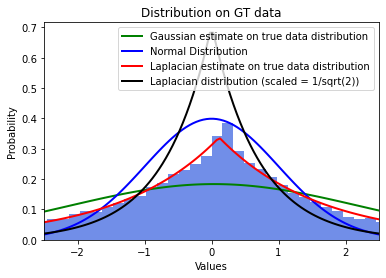

In [21]:
std_data, mu_data = torch.std_mean(vals)

# the histogram of the data
n, bins, patches = plt.hist(vals.numpy(), 250, density=True, facecolor='royalblue', alpha=0.75)


plt.xlabel('Values')
plt.ylabel('Probability')
plt.xlim(-2.5, 2.5)
plt.title('Distribution on GT data')

xmin, xmax = plt.xlim()
x = torch.linspace(xmin, xmax, 100)
# p = [NormalDist(mu, std).pdf(xx) for xx in x]
# plt.plot(x, p, 'k', linewidth=2)

p = [NormalDist(mu_data, std_data).pdf(xx) for xx in x]
plt.plot(x, p, 'g', linewidth=2, label='Gaussian estimate on true data distribution')

p = [NormalDist(0, 1).pdf(xx) for xx in x]
plt.plot(x, p, 'b', linewidth=2, label='Normal Distribution')

loc, scale = laplace.fit(vals.numpy())
p = laplace.pdf(x, loc, scale)
plt.plot(x, p, 'r', linewidth=2, label='Laplacian estimate on true data distribution')

p = laplace.pdf(x, 0, 1/math.sqrt(2))
plt.plot(x, p, 'k', linewidth=2, label='Laplacian distribution (scaled = 1/sqrt(2))')

plt.legend()

b = cfg.case.user.num_data_points
func = cfg.case.server.model_modification.linfunc
bins = cfg.case.server.model_modification.num_bins
plt.savefig(f"linear_fn_{func}_data{b}_b{bins}.pdf", bbox_inches='tight')

plt.show()

In [22]:
len(vals)

50000